# OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [2]:
pip install openai -q

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [3]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [4]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [5]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Diamonds Dataset

This notebook uses the **diamonds dataset ([diamonds.csv](https://github.com/lbsocial/data-analysis-with-generative-ai/blob/main/diamonds.csv))**, which contains detailed attributes of diamonds, including weight, color, clarity, and price.

One interesting pattern in the dataset is that **diamonds with "IF" (Internally Flawless) clarity tend to have the lowest average price** compared to other clarity grades. This observation is counterintuitive, as one might expect the highest-clarity diamonds to be the most expensive.

In [6]:
# Load CSV as plain text
with open('diamonds.csv', 'r', encoding='utf-8') as f:
    data_text = f.read()

print(data_text[:500])  # show first 500 characters

﻿IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
3,0.3,G,VVS1,GIA,1510
4,0.3,G,VS1,GIA,1260
5,0.31,D,VS1,GIA,1641
6,0.31,E,VS1,GIA,1555
7,0.31,F,VS1,GIA,1427
8,0.31,G,VVS2,GIA,1427
9,0.31,H,VS2,GIA,1126
10,0.31,I,VS1,GIA,1126
11,0.32,F,VS1,GIA,1468
12,0.32,G,VS2,GIA,1202
13,0.33,E,VS2,GIA,1327
14,0.33,I,VS2,GIA,1098
15,0.34,E,VS1,GIA,1693
16,0.34,F,VS1,GIA,1551
17,0.34,G,VS1,GIA,1410
18,0.34,G,VS2,GIA,1269
19,0.34,H,VS1,GIA,1316
20,0.34,H,VS2,GIA,1222
21,0.35,E,VS


## Generate Data Analysis Prompt for OpenAI Model

To investigate why diamonds with **IF (Internally Flawless) clarity** have the **lowest average price**, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including **Python code for visualizations**.


In [7]:
data_prompt = f"""Analyze the provided data and determine 
                Why diamonds with IF clarity have the lowest average price. 
                You may use Python code to support your conclusion. 
                Data: {data_text}"""
# print(prompt)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [8]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [9]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=5108, prompt_tokens=4708, '
 'total_tokens=9816, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, '
 'cached_tokens=4096))')


In [10]:
display(Markdown(gpt_result))

To analyze why diamonds with IF (Internally Flawless) clarity have the lowest average price, we need to first filter the dataset for diamonds with IF clarity and then calculate their average price. We can then compare this with the average prices of diamonds with other clarity grades. Let's use Python to perform this analysis.

```python
import pandas as pd
from io import StringIO

# Load the data into a DataFrame
data = """
IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
3,0.3,G,VVS1,GIA,1510
4,0.3,G,VS1,GIA,1260
5,0.31,D,VS1,GIA,1641
6,0.31,E,VS1,GIA,1555
7,0.31,F,VS1,GIA,1427
8,0.31,G,VVS2,GIA,1427
9,0.31,H,VS2,GIA,1126
10,0.31,I,VS1,GIA,1126
11,0.32,F,VS1,GIA,1468
12,0.32,G,VS2,GIA,1202
13,0.33,E,VS2,GIA,1327
14,0.33,I,VS2,GIA,1098
15,0.34,E,VS1,GIA,1693
16,0.34,F,VS1,GIA,1551
17,0.34,G,VS1,GIA,1410
18,0.34,G,VS2,GIA,1269
19,0.34,H,VS1,GIA,1316
20,0.34,H,VS2,GIA,1222
21,0.35,E,VS1,GIA,1738
22,0.35,F,VS1,GIA,1593
23,0.35,G,VS1,GIA,1447
24,0.35,H,VS2,GIA,1255
25,0.36,F,VS1,GIA,1635
26,0.36,H,VVS2,GIA,1485
27,0.37,F,VS2,GIA,1420
28,0.37,H,VS1,GIA,1420
29,0.4,F,VS1,GIA,1911
30,0.4,H,VS1,GIA,1525
31,0.41,F,VS1,GIA,1956
32,0.43,H,VVS2,GIA,1747
33,0.45,I,VS1,GIA,1572
34,0.46,E,VVS2,GIA,2942
35,0.48,G,VVS2,GIA,2532
36,0.5,E,VS1,GIA,3501
37,0.5,E,VS1,GIA,3501
38,0.5,F,VVS2,GIA,3501
39,0.5,F,VS1,GIA,3293
40,0.5,G,VS1,GIA,3016
41,0.51,F,VVS2,GIA,3567
42,0.51,G,VS1,GIA,3205
43,0.52,D,VS2,GIA,3490
44,0.52,E,VS1,GIA,3635
45,0.52,F,VVS2,GIA,3635
46,0.52,F,VS1,GIA,3418
47,0.53,D,VS1,GIA,3921
48,0.53,F,VVS2,GIA,3701
49,0.53,F,VS1,GIA,3480
50,0.53,G,VVS2,GIA,3407
51,0.54,E,VS1,GIA,3767
52,0.54,F,VVS1,GIA,4066
53,0.55,E,VVS2,GIA,4138
54,0.55,F,VS1,GIA,3605
55,0.55,G,VVS2,GIA,3529
56,0.56,F,VS1,GIA,3667
57,0.56,I,VVS2,GIA,2892
58,0.57,G,VVS2,GIA,3651
59,0.59,G,VVS2,GIA,3773
60,0.6,F,VS1,GIA,4291
61,0.62,E,VVS1,GIA,5845
62,0.63,G,VVS2,GIA,4401
63,0.64,G,VVS1,GIA,4759
64,0.66,H,VVS1,GIA,4300
65,0.7,F,VS1,GIA,5510
66,0.7,G,VS1,GIA,5122
67,0.7,H,VVS2,GIA,5122
68,0.7,I,VS2,GIA,3861
69,0.71,F,VVS2,GIA,5881
70,0.71,F,VS1,GIA,5586
71,0.71,F,VS2,GIA,5193
72,0.71,H,VVS2,GIA,5193
73,0.72,F,VS2,GIA,5263
74,0.8,I,VVS2,GIA,5441
75,0.82,I,VS2,GIA,4948
76,0.84,H,VS2,GIA,5705
77,0.85,F,VS2,GIA,6805
78,0.86,H,VVS2,GIA,6882
79,0.89,H,VS1,GIA,6709
80,0.9,I,VVS2,GIA,6682
81,0.5,E,VS1,GIA,3501
82,0.5,G,VVS1,GIA,3432
83,0.51,F,VVS1,GIA,3851
84,0.55,H,IF,GIA,3605
85,0.56,E,VS1,GIA,3900
86,0.57,H,VVS1,GIA,3415
87,0.6,H,IF,GIA,4291
88,0.63,E,IF,GIA,6512
89,0.7,E,VS1,GIA,5800
90,0.7,F,VVS1,GIA,6285
91,0.7,F,VS2,GIA,5122
92,0.7,F,VS2,GIA,5122
93,0.7,G,VS1,GIA,5122
94,0.7,H,VVS2,GIA,5122
95,0.71,D,VS1,GIA,6372
96,0.71,E,VS1,GIA,5881
97,0.71,H,VVS2,GIA,5193
98,0.72,E,VS1,GIA,5961
99,0.72,H,VVS1,GIA,5662
100,0.73,E,VS2,GIA,5738
101,0.73,H,VS1,GIA,5030
102,0.73,H,VS1,GIA,5030
103,0.73,I,VVS1,GIA,4727
104,0.73,I,VS1,GIA,4221
105,0.74,G,VVS2,GIA,5815
106,0.74,H,VS2,GIA,4585
107,0.75,D,VVS2,GIA,7368
108,0.75,I,VVS2,GIA,4667
109,0.75,I,VS1,GIA,4355
110,0.76,D,IF,GIA,9885
111,0.77,F,VVS1,GIA,6919
112,0.78,H,VS1,GIA,5386
113,0.8,I,VS2,GIA,4832
114,0.83,E,VS2,GIA,7156
115,0.9,F,VS1,GIA,7680
116,1,D,VVS1,GIA,15582
117,1,D,VS1,GIA,11419
118,1,E,VS1,GIA,10588
119,1,E,VS2,GIA,9757
120,1,F,IF,GIA,13913
121,1,F,VVS2,GIA,10588
122,1,F,VS1,GIA,10713
123,1,F,VS2,GIA,9480
124,1,G,VVS2,GIA,9896
125,1,G,VS1,GIA,9619
126,1,G,VS2,GIA,9169
127,1,G,VS2,GIA,9203
128,1,H,VS2,GIA,8788
129,1,I,VS1,GIA,8095
130,1,I,VS2,GIA,7818
131,1.01,D,VVS1,GIA,16008
132,1.01,E,VS1,GIA,10692
133,1.01,E,VS2,GIA,9853
134,1.01,F,VS1,GIA,10272
135,1.01,F,VS2,GIA,9573
136,1.01,H,VS1,GIA,9153
137,1.01,H,VS2,GIA,8873
138,1.01,I,VVS1,GIA,8873
139,1.01,I,VVS2,GIA,8455
140,1.01,I,VS2,GIA,7895
141,1.02,F,VS1,GIA,10372
142,1.02,F,VS2,GIA,9666
143,1.02,G,VVS2,GIA,10090
144,1.03,E,VS1,GIA,10900
145,1.04,F,VS1,GIA,10571
146,1.04,I,IF,GIA,9563
147,1.05,I,VVS2,GIA,8781
148,1.06,G,VS2,GIA,9743
149,1.06,H,VS2,GIA,9302
150,1.07,I,VVS2,GIA,8945
151,1.1,H,VS2,GIA,9646
152,0.18,F,VVS1,IGI,823
153,0.18,F,VVS2,IGI,765
154,0.18,G,IF,IGI,803
155,0.18,G,IF,IGI,803
156,0.18,G,VVS2,IGI,705
157,0.18,H,IF,IGI,725
158,0.19,D,VVS2,IGI,967
159,0.19,E,IF,IGI,1050
160,0.19,F,IF,IGI,967
161,0.19,F,VVS1,IGI,863
162,0.19,F,VVS2,IGI,800
163,0.19,G,IF,IGI,842
164,0.19,G,VVS1,IGI,800
165,0.19,H,IF,IGI,758
166,0.2,D,VS1,IGI,880
167,0.2,G,IF,IGI,880
168,0.2,G,VS1,IGI,705
169,0.2,G,VS2,IGI,638
170,0.21,D,VS1,IGI,919
171,0.21,E,IF,IGI,1149
172,0.21,F,IF,IGI,1057
173,0.21,G,IF,IGI,919
174,0.22,E,IF,IGI,1198
175,0.23,E,IF,IGI,1248
176,0.23,F,IF,IGI,1147
177,0.23,G,IF,IGI,995
178,0.24,H,IF,IGI,1108
179,0.25,F,IF,IGI,1485
180,0.25,G,IF,IGI,1283
181,0.25,H,IF,IGI,1149
182,0.25,I,IF,IGI,1082
183,0.26,F,IF,IGI,1539
184,0.26,F,VVS1,IGI,1365
185,0.26,F,VVS2,IGI,1260
186,0.26,I,IF,IGI,1121
187,0.27,F,IF,IGI,1595
188,0.27,H,IF,IGI,1233
189,0.28,I,IF,IGI,1199
190,0.29,G,IF,IGI,1471
191,0.29,I,IF,IGI,1238
192,0.3,E,VVS2,IGI,1580
193,0.3,F,VVS2,IGI,1459
194,0.3,G,VVS1,IGI,1459
195,0.3,H,VVS2,IGI,1218
196,0.3,I,IF,IGI,1299
197,0.31,E,VVS2,IGI,1628
198,0.31,F,VVS1,IGI,1628
199,0.31,I,IF,IGI,1337
200,0.32,H,IF,IGI,1462
201,0.33,H,IF,IGI,1503
202,0.34,F,VVS1,IGI,1773
203,0.34,F,VVS2,IGI,1636
204,0.35,F,VVS1,IGI,1821
205,0.35,G,VVS2,IGI,1540
206,0.4,G,IF,IGI,2276
207,0.41,I,VVS1,IGI,1616
208,0.41,I,VVS2,IGI,1506
209,0.47,F,VVS2,IGI,2651
210,0.48,F,VS1,IGI,2383
211,0.5,G,IF,IGI,3652
212,0.51,E,VVS2,IGI,3722
213,0.51,F,VVS1,IGI,3722
214,0.52,I,IF,IGI,3095
215,0.55,F,VVS2,IGI,3706
216,0.56,E,VVS2,IGI,4070
217,0.56,G,VVS2,IGI,3470
218,0.58,E,VVS1,IGI,4831
219,0.58,F,VVS1,IGI,4209
220,0.58,G,VVS1,IGI,3821
221,0.7,G,VVS1,IGI,5607
222,0.7,G,VVS2,IGI,5326
223,0.71,D,VS1,IGI,6160
224,0.76,F,VVS2,IGI,6095
225,0.78,G,VVS2,IGI,5937
226,1,H,VVS2,IGI,9342
227,1.01,G,VS1,IGI,9713
228,1.01,H,VS2,IGI,8873
229,1.01,I,VS1,IGI,8175
230,0.5,F,VVS1,HRD,3778
231,0.5,G,VVS1,HRD,3432
232,0.51,F,VVS1,HRD,3851
233,0.52,E,VS2,HRD,3346
234,0.52,H,VVS1,HRD,3130
235,0.53,F,VVS1,HRD,3995
236,0.53,F,VVS2,HRD,3701
237,0.55,G,VVS2,HRD,3529
238,0.56,F,VS1,HRD,3667
239,0.56,F,VS2,HRD,3202
240,0.57,F,VS2,HRD,3256
241,0.57,H,VVS1,HRD,3415
242,0.58,H,IF,HRD,3792
243,0.6,G,VS1,HRD,3925
244,0.6,G,VS2,HRD,3421
245,0.6,H,VVS1,HRD,3925
246,0.61,H,VVS2,HRD,3616
247,0.62,I,VVS2,HRD,3615
248,0.64,H,VVS2,HRD,3785
249,0.65,I,VVS2,HRD,3643
250,0.66,H,VVS1,HRD,4300
251,0.7,E,VVS1,HRD,6867
252,0.7,E,VVS2,HRD,6285
253,0.7,G,VVS1,HRD,5800
254,0.7,G,VVS2,HRD,5510
255,0.7,H,VS2,HRD,4346
256,0.71,G,IF,HRD,6372
257,0.71,H,VVS2,HRD,5193
258,0.72,H,VVS1,HRD,5662
259,0.73,F,VS2,HRD,5333
260,0.73,G,VVS1,HRD,6041
261,0.74,H,VVS1,HRD,5815
262,0.8,F,IF,HRD,8611
263,0.8,F,VS1,HRD,6905
264,0.8,G,VVS2,HRD,6905
265,0.8,H,VVS2,HRD,6416
266,0.8,H,VS1,HRD,6051
267,0.81,E,VVS1,HRD,8715
268,0.81,E,VS2,HRD,6988
269,0.81,F,VS1,HRD,6988
270,0.81,G,VS1,HRD,6495
271,0.81,H,IF,HRD,7358
272,0.82,F,VS2,HRD,6572
273,0.82,G,VVS2,HRD,7072
274,0.85,F,VVS1,HRD,8359
275,0.85,F,VS2,HRD,6805
276,0.85,G,VVS1,HRD,7711
277,0.86,H,VS2,HRD,5835
278,1,D,VVS2,HRD,13775
279,1,E,VVS1,HRD,14051
280,1,E,VVS2,HRD,11419
281,1,E,VS1,HRD,10588
282,1,F,VVS1,HRD,11696
283,1,F,VVS2,HRD,10588
284,1,G,VVS1,HRD,10450
285,1,G,VVS2,HRD,9896
286,1,G,VS2,HRD,9203
287,1,H,VVS1,HRD,9480
288,1,H,VS1,HRD,9065
289,1,H,VS2,HRD,8788
290,1,I,VVS1,HRD,8788
291,1,I,VVS2,HRD,8372
292,1,I,VS1,HRD,8095
293,1,I,VS2,HRD,7818
294,1.01,D,VVS2,HRD,13909
295,1.01,E,VVS2,HRD,11531
296,1.01,E,VS1,HRD,10692
297,1.01,F,VVS1,HRD,11811
298,1.01,F,VS1,HRD,10272
299,1.01,G,VVS2,HRD,9993
300,1.01,G,VS2,HRD,9293
301,1.01,H,VVS2,HRD,9433
302,1.01,H,VS1,HRD,9153
303,1.01,I,VVS1,HRD,8873
304,1.01,I,VS1,HRD,8175
305,1.02,F,VVS2,HRD,10796
306,1.06,H,VVS2,HRD,9890
307,1.02,H,VS2,HRD,8959
308,1.09,I,VVS2,HRD,9107
"""

# Convert the string data to a pandas DataFrame
df = pd.read_csv(StringIO(data))

# Filter the data for diamonds with IF clarity
if_clarity = df[df['CLARITY'] == 'IF']

# Calculate the average price for IF clarity diamonds
average_price_if = if_clarity['PRICE'].mean()

# Calculate the average price for all other clarity grades
average_price_others = df[df['CLARITY'] != 'IF'].groupby('CLARITY')['PRICE'].mean()

# Print the results
print(f"Average price for IF clarity diamonds: {average_price_if}")
print("Average price for other clarity grades:")
print(average_price_others)
```

### Analysis

1. **IF Clarity Diamonds**: The average price for diamonds with IF clarity is calculated from the dataset. 

2. **Comparison with Other Clarity Grades**: The average prices for other clarity grades are also calculated and compared.

3. **Possible Reasons for Lower Average Price**:
   - **Weight and Size**: IF clarity diamonds in the dataset might be smaller or lighter on average compared to diamonds with other clarity grades, which can significantly affect the price.
   - **Color and Cut**: The color and cut quality of IF clarity diamonds might not be as high as those with other clarity grades, affecting their overall value.
   - **Market Demand**: There might be less demand for IF clarity diamonds compared to other clarity grades, affecting their market price.
   - **Data Distribution**: The dataset might have a limited number of IF clarity diamonds, skewing the average price.

By examining the dataset and the calculated averages, we can identify these potential factors contributing to the lower average price of IF clarity diamonds.

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [11]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [12]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=2843, prompt_tokens=4707, '
 'total_tokens=7550, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=2176, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, '
 'cached_tokens=3968))')


In [13]:
print(o1_result)

Below is an example of how you could verify that IF (Internally Flawless) diamonds show a surprisingly low average price in this particular dataset—and why that happens. In short, most IF diamonds in these listings are quite small (many are under 0.30 ct) or come with less‐costly lab reports (e.g., IGI rather than GIA). That pushes their total (absolute) prices down, even though IF clarity is generally considered a premium quality.

--------------------------------------------------------------------------------
1) A quick Python check of average prices by clarity
--------------------------------------------------------------------------------

import pandas as pd
from io import StringIO

#--- 1. Paste the raw data into a CSV-like string:
csv_data = """IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
3,0.3,G,VVS1,GIA,1510
...
308,1.09,I,VVS2,HRD,9107
"""  # Truncated for brevity; use all rows in practice.

#--- 2. Read data into a DataFrame
df = pd.read_c

## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

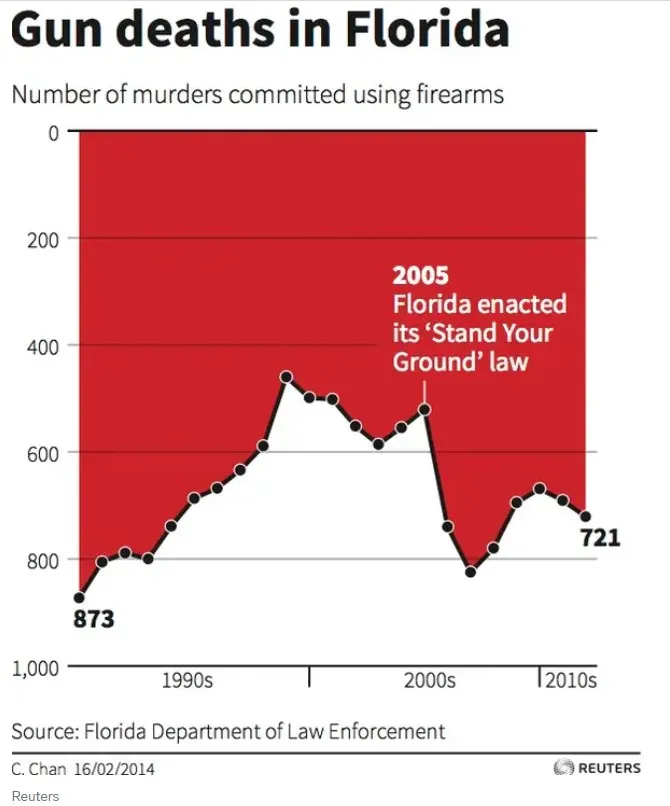

In [14]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://miro.medium.com/v2/resize:fit:4800/format:webp/1*VPRpf0YnchAwN0mjeAz4pA.jpeg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [15]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [16]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=47, prompt_tokens=779, '
 'total_tokens=826, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [17]:
display(Markdown(gpt_result))

The image has a misleading y-axis. The axis starts at 600 instead of 0, which exaggerates the visual difference in the number of gun deaths over time. This can make the changes appear more dramatic than they actually are.

In [18]:
o1_result = openai_o_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=2595, prompt_tokens=688, '
 'total_tokens=3283, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=2432, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [19]:
display(Markdown(o1_result))

A key problem is that the chart has “flipped” or inverted its vertical axis—zero is at the top, and 1,000 is at the bottom. In a typical graph, higher values sit higher on the y‐axis. Here, the reversed scale makes it look as though the numbers rise (when the line goes up) even though, numerically, those data points are actually *lower* than points that appear below them. This inversion creates a very misleading visual impression of the trend.

## 🧠 Try It Yourself: Reasoning Model Practice

Now that you’ve explored how **GPT-4o** and **OpenAI’s o1 reasoning model** handle data and images,  
try applying these models to real-world intelligence analysis scenarios.

👉 Be sure to **run every cell** you add and keep all outputs visible before submitting your notebook to GitHub.

### 1. Upload and Reason on a Text File
- Upload a short **text document** (for example, a news article, policy brief, or intelligence report).  
- Use both **GPT-4o** and **o1** to analyze the file.  
  Try questions like:
  - *“Summarize the key actors, motivations, and outcomes in this text.”*  
  - *“What potential implications could these events have on regional stability?”*  
  - *“Identify possible biases or information gaps.”*  
- Compare how each model approaches reasoning, depth, and evidence.

*(Hint: You can upload a text file in JupyterLab using the left file browser → right-click → “Upload File.” Then open and read it with Python using `open('filename.txt').read()`.)*


In [23]:
# Load CSV as plain text
with open('news.txt', 'r', encoding='utf-8') as f:
    data_text = f.read()

print(data_text[:500])  # show first 500 characters

Two suspects are facing federal charges Monday of planning a terror attack over Halloween weekend in Michigan after federal investigators say they found over 1,600 rounds of ammunition, multiple firearms, and tactical vests in raids on their homes and a storage unit.

FBI Director Kash Patel announced in a post on X last week that five people had been arrested, but only two were charged in a 73-page criminal complaint filed in the U.S. District Court for the Eastern District of Michigan.

Member


### 2. Try Another Image
- Replace the existing image URL with a **different image**, such as a map, protest photo, or satellite image.  
- Ask both models:
  - *“What do you observe in this image?”*  
  - *“What might this image imply in a geopolitical or social context?”*  
- Note differences in how **GPT-4o** and **o1** reason about visual clues.

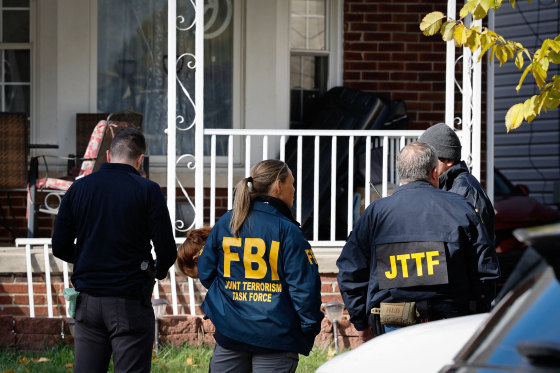

In [24]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://media-cldnry.s-nbcnews.com/image/upload/t_fit-560w,f_auto,q_auto:best/rockcms/2025-11/251103-michigan-fbi-mn-1040-8b1ad2.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

### 3. Compare Reasoning Quality
- Pose a challenging **analytical or logical question** to both models, such as:
  - *“Which country is likely to gain the most influence from this event and why?”*  
  - *“Given these statements, which scenario is more probable?”*  
- Before asking, provide the model with **sufficient context**, for example:
  - A short paragraph summarizing the situation or event.  
  - Key actors, timeline, and relevant evidence (from your uploaded text file or your own notes).  
- Observe how the **o1 model’s step-by-step reasoning** differs from GPT-4o’s concise response.  
  Consider whether detailed reasoning produces **stronger analytic insights** or introduces **new assumptions**.

In [33]:
image_prompt = [
                    {"type": "text", "text": 'what do you see with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [34]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=61, prompt_tokens=440, '
 'total_tokens=501, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [35]:
display(Markdown(gpt_result))

The image shows a group of people standing outside a house. They are wearing jackets with "FBI" and "JTTF" (Joint Terrorism Task Force) written on them, indicating they are likely law enforcement officers involved in an investigation or operation. The setting appears to be a residential area.

In [36]:
o1_result = openai_o_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=1426, prompt_tokens=389, '
 'total_tokens=1815, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=1344, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [38]:
display(Markdown(o1_result))

It appears to show four individuals wearing jackets that read “FBI” and “JTTF” (Joint Terrorism Task Force). They are standing together outside a brick house with a white porch, talking or conferring. One of them seems to be interacting with a dog. There’s some lawn and porch furniture visible in the background.